This assignment will give you a real (active) research topic that I've discussed a little bit in class: predicting carbon storage as a function of high-resolution gridded data. In the class google drive you will find all the data you need in the Soyo_tile folder.

This assignment will have you use the automated variable selection approach within LASSO to deal with a common situation in regressions on raster-stacks: we have so much data everything is significant but will lead to massive overfitting. The basic approach used here will involve reading in 2d rasters, flattening them into a 1d column ready to add to a dataframe shaped object, which we will use as our X matrix.

Please turn in the completed Notebook (.ipynb) file that includes the results you generate. 

Below is some starter code along with specific assignment questions.


In [68]:
# Load libraries
import numpy as np
import os
from osgeo import gdal
from sklearn.linear_model import Lasso
from matplotlib import pyplot as plt
from statsmodels.api import OLS
from sklearn.metrics import mean_squared_error, r2_score

## Step 1: Download the data and set paths

Download the latest data from the class's google drive. In there, you will need the the files in `Data/python_assignment_2` data and assign a relative path to the `soyo_tile` directory in that assignment directory. It is your task to ensure your script runs in the right location and the data is stored in the right location that this relative path works.

In [17]:
# Step 1 code
data_dir = '../../../../data' 
data_dir = os.path.join(data_dir, 'soyo_tile')
os.listdir(data_dir)

['agb_observed_baccini_2000_30m.tif',
 'alt_30s.tif',
 'AWCh1_M_sl1_250m.tif',
 'BDRICM_M_250m.tif',
 'BDRLOG_M_250m.tif',
 'BLDFIE_M_sl1_250m.tif',
 'CLYPPT_M_sl1_250m.tif',
 'CRFVOL_M_sl1_250m.tif',
 'data_readme.docx',
 'HISTPR_250m.tif',
 'OCDENS_M_sl1_250m.tif',
 'PHIHOX_M_sl1_250m.tif',
 'roughness_30s.tif',
 'SLGWRB_250m.tif',
 'slope_30s.tif',
 'SLTPPT_M_sl1_250m.tif',
 'terrain_ruggedness_index_30s.tif',
 'TEXMHT_M_sl1_250m.tif',
 'wc2.0_bio_30s_01.tif',
 'wc2.0_bio_30s_12.tif']

## Step 2: Set raster paths 

Assign each of the raster paths in the directory to a dictionary for later use. I've included most of the code (so you don't have to waste your time typing), but add in the missing paths.

In [18]:
# Step 2 code

raster_paths = {}

# First is the dependent varable, Above Ground Carbon (AGB) in tons, measured at 30 meters globally (here it is clipped to a smaller area)
raster_paths['agb_observed_baccini_2000_30m'] = os.path.join(data_dir, "agb_observed_baccini_2000_30m.tif")

# Here are some of the independent variables
raster_paths['CRFVOL_M_sl1_250m'] = os.path.join(data_dir, "CRFVOL_M_sl1_250m.tif")
raster_paths['HISTPR_250m'] = os.path.join(data_dir, "HISTPR_250m.tif")
raster_paths['OCDENS_M_sl1_250m'] = os.path.join(data_dir, "OCDENS_M_sl1_250m.tif")
raster_paths['PHIHOX_M_sl1_250m'] = os.path.join(data_dir, "PHIHOX_M_sl1_250m.tif")
raster_paths['roughness_30s'] = os.path.join(data_dir, "roughness_30s.tif")
raster_paths['SLGWRB_250m'] = os.path.join(data_dir, "SLGWRB_250m.tif")
raster_paths['SLTPPT_M_sl1_250m'] = os.path.join(data_dir, "SLTPPT_M_sl1_250m.tif")
raster_paths['terrain_ruggedness_index_30s'] = os.path.join(data_dir, "terrain_ruggedness_index_30s.tif")
raster_paths['TEXMHT_M_sl1_250m'] = os.path.join(data_dir, "TEXMHT_M_sl1_250m.tif")
raster_paths['wc2.0_bio_30s_01'] = os.path.join(data_dir, "wc2.0_bio_30s_01.tif")
raster_paths['alt_30s'] = os.path.join(data_dir, "alt_30s.tif")
raster_paths['AWCh1_M_sl1_250m'] = os.path.join(data_dir, "AWCh1_M_sl1_250m.tif")
raster_paths['BDRICM_M_250m'] = os.path.join(data_dir, "BDRICM_M_250m.tif")
raster_paths['BDRLOG_M_250m'] = os.path.join(data_dir, "BDRLOG_M_250m.tif")
raster_paths['BLDFIE_M_sl1_250m'] = os.path.join(data_dir, "BLDFIE_M_sl1_250m.tif")

## Step 3: Open the rasters

Our dependent variable will be 30 meter observations of carbon storage from Baccini et al. (unpublished, but soon to be published) data. The label I assigned in the dictionary above was agb_observed_baccini_2000_30m for this variable. Use gdal.Open, GetRasterBand(1) and ReadAsArray() to read this geotiff as a numpy file

Side note: If you get an error like: "ERROR 4: This is a BigTIFF file.  BigTIFF is not supported by this version of GDAL and libtiff." make sure you have installed gdal with the mamba method from lecture 1. 

In [11]:
# Step 3 code

# Save Y variable file to variable
y = raster_paths['agb_observed_baccini_2000_30m']
# Open file
y_rast = gdal.Open(y)
# Get band 1
y_band = y_rast.GetRasterBand(1)
# Convert band to array
y_arr = y_band.ReadAsArray()

print(y_arr)

[[123 122  75 ... 130 128 125]
 [125 124 124 ... 121 130 124]
 [125 128 126 ... 124 124 126]
 ...
 [  0   0   0 ... 155 136 143]
 [  0   0   0 ... 135 132 198]
 [  0   0   0 ... 135 123 119]]


## Step 4: Define some arrays

Create an empty numpy array (or full of zeros) of the right shape to house all our raster data. A very CPU-efficient way of arranging a stack of 2d rasters (which would be 3d once stacked up), is to flatten each 2d raster into a longer 1d array. This will go into our X matrix. In order to create the right sized X matrix, first get the n_obs and n_vars by inspecting the dependent variable raster and the dictionary of inputs above. Note that the n_vars should be the number of independent AND dependent variables.

In [43]:
# Step 4 code

from sklearn.preprocessing import StandardScaler  # Example usage of scikit-learn

# Initialize counters
n_obs = 0
n_vars = 0

# Iterate through TIFF files
for key, file_path in raster_paths.items():
    # Read TIFF file using GDAL
    dataset = gdal.Open(file_path)

    # Get information from the dataset
    observations = dataset.RasterYSize
    variables = dataset.RasterCount

    # Accumulate counts
    n_obs += observations
    n_vars += variables

    # Additional processing using scikit-learn (example: standard scaling)
    data_arr = np.array(dataset.ReadAsArray())
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data_arr)

    # Close the dataset
    dataset = None

n_obs # number of obs before flattening...
total_obs = n_obs * 125
# Print or use the accumulated counts
print(f"Number of Observations: {total_obs}")
print(f"Number of Variables: {n_vars}")



Number of Observations: 4000000
Number of Variables: 16


In [44]:
# Tuple of shape: obs x vars
shape = (total_obs, n_vars)
# Create empty array
data_array = np.zeros(shape)
print(shape)

(4000000, 16)


## Step 5: Load all the independent variables

- Iterate through the dictionary and load each raster as a 2d array
- flatten it to 1d using the .flatten() method in numpy
- Assign this 1d array to the correct column of the data array. By convention, the depvar will be the first column.

Hint, assuming you have arranged your X array in the correct way, it should have observations (pixels) as rows and variables as cols. Given that each flattened array is for one variable and is as long as there are rows, a convenient way of assigning it would be to use numpy slice notation, potentially similar to:

`data_array[:, column_index_integer]`

The first colon just denotes the whole row and the column index is an integer you could create pointing to the right row.

Some incomplete code to get you started is below.

In [108]:
# Step 5 code

col_index = 0
feature_names = []

# Iterate through all raster files in dictionary
for name, path in raster_paths.items():
    print('Loading', path)
    # Open file
    rast = gdal.Open(path)
    band = rast.GetRasterBand(1)
    flattened_raster_array = band.ReadAsArray().flatten()
    # print(np.unique(flattened_raster_array))
    print('Populating column', col_index)
    data_array[:, col_index] = flattened_raster_array
    feature_names.append(name)

    col_index += 1
    # Close file
    rast = None


Loading ../../../../data\soyo_tile\agb_observed_baccini_2000_30m.tif
Populating column 0
Loading ../../../../data\soyo_tile\CRFVOL_M_sl1_250m.tif
Populating column 1
Loading ../../../../data\soyo_tile\HISTPR_250m.tif
Populating column 2
Loading ../../../../data\soyo_tile\OCDENS_M_sl1_250m.tif
Populating column 3
Loading ../../../../data\soyo_tile\PHIHOX_M_sl1_250m.tif
Populating column 4
Loading ../../../../data\soyo_tile\roughness_30s.tif
Populating column 5
Loading ../../../../data\soyo_tile\SLGWRB_250m.tif
Populating column 6
Loading ../../../../data\soyo_tile\SLTPPT_M_sl1_250m.tif
Populating column 7
Loading ../../../../data\soyo_tile\terrain_ruggedness_index_30s.tif
Populating column 8
Loading ../../../../data\soyo_tile\TEXMHT_M_sl1_250m.tif
Populating column 9
Loading ../../../../data\soyo_tile\wc2.0_bio_30s_01.tif
Populating column 10
Loading ../../../../data\soyo_tile\alt_30s.tif
Populating column 11
Loading ../../../../data\soyo_tile\AWCh1_M_sl1_250m.tif
Populating column 12
L

# Step 6: 

Extract the first array row of the data_array and assign it to y. Assign the rest to X.

In [87]:
# Step 6 code
y = data_array[:, 0]
x = data_array[:, 1:]

# Step 7:

Split the X and y into testing and training data such that the training data is the first million pixels and the testing data is the next 200,000. Do this using numpy slice notation on the X and y variables you created.

In [89]:
# Step 7 code
train_obs = 1000000
test_obs = 2000000
y_train = y[0:train_obs]
X_train = x[0:train_obs, :]
y_test = y[train_obs+1:train_obs+1+test_obs]
X_test = x[train_obs+1:train_obs+1+test_obs, :]

# Step 8 (optional but useful):

To make the code run faster, we are going to use every 10th pixel. We can easily get this via numpy slicing again, using x_train[::10] to get every 10th pixel.

In [90]:
# Step 8 code
y_train[::10]
X_train[::10]

array([[-1.000e+00,  7.000e+00,  1.750e+02, ...,  2.000e+02,  1.000e+00,
         1.436e+03],
       [-1.000e+00,  6.000e+00,  1.680e+02, ...,  2.000e+02, -1.000e+00,
         1.390e+03],
       [-1.000e+00,  6.000e+00,  1.690e+02, ...,  2.000e+02, -1.000e+00,
         1.377e+03],
       ...,
       [-1.000e+00,  2.000e+00,  1.200e+02, ...,  2.000e+02, -1.000e+00,
         1.359e+03],
       [-1.000e+00,  1.000e+00,  1.210e+02, ...,  2.000e+02,  3.000e+00,
         1.368e+03],
       [-1.000e+00,  1.000e+00,  1.230e+02, ...,  2.000e+02,  2.000e+00,
         1.365e+03]])

# Step 9:

Create a Lasso object (using the default penalty term alpha) and fit it to the training data. Create and print out a vector of predicted carbon values. Also print out the score using the lasso object's .score() method on the TESTING data. Print out the fitted lasso score.

In [92]:
# Step 9 code

# Create Lasso object
model_lasso = Lasso(alpha=1.0, random_state=0, max_iter=10000)

# Fit the model
y_train_hat_lasso = model_lasso.fit(X_train, y_train)

# Prediction
y_pred = model_lasso.predict(X_test)

# View score
print(y_train_hat_lasso.score(X_test, y_test))

-0.6206354561350587


# Step 10, optional and just for fun:.

To view how our projections LOOK, we can create a predicted matrix on the whole X, reshape it back into the original 2d shape and look at it. You can compare this to the input array to visualize how it looks. Note that this will only work if you name your objects like mine.

In [ ]:
# Step 10 code

# Step 11:

Create a list of 30 alphas using ` np.logspace(-1, 3, 30)`. 

Using a for loop iterate over those alphas and run the Lasso model like above, but using the alpha values in the loop. Print out the fit score at each step. Using matplotlib, plot how this value changes as alpha changes. Finally, extract the best alpha of the bunch. 

In [93]:
# Step 11 code 

# Define dict for scores
scores = {}

# Create list of alphas
alpha_list = np.logspace(-1, 3, 30)

for alpha in alpha_list:
    model_lasso = Lasso(alpha=alpha, random_state=0, max_iter=10000)
    model_lasso.fit(X_train, y_train)
    y_train_hat_lasso = model_lasso.predict(X_train)
    r2 = r2_score(y_train, y_train_hat_lasso)
    scores[alpha] = r2
    print('Alpha', alpha, 'r2', r2)

# Quick way to get the value from the highest-valued dictionary entry
best_alpha = max(scores, key=scores.get)

# print best_alpha with all the significant digits
print('best_alpha', best_alpha)


Alpha 0.1 r2 0.5982431818702818
Alpha 0.1373823795883263 r2 0.5982334402077794
Alpha 0.18873918221350972 r2 0.5982150585809618
Alpha 0.2592943797404667 r2 0.5981803688109031
Alpha 0.3562247890262442 r2 0.5981149063933093
Alpha 0.4893900918477494 r2 0.5979913851526988
Alpha 0.6723357536499337 r2 0.5977583109386742
Alpha 0.9236708571873861 r2 0.5973185454245731
Alpha 1.2689610031679222 r2 0.5966023395706236
Alpha 1.743328822199988 r2 0.5955545906682953
Alpha 2.395026619987486 r2 0.5935772330613508
Alpha 3.2903445623126677 r2 0.5909188740445962
Alpha 4.520353656360243 r2 0.5869388552262478
Alpha 6.2101694189156165 r2 0.5815217217094848
Alpha 8.531678524172806 r2 0.5742088714076911
Alpha 11.721022975334806 r2 0.5601688305647465
Alpha 16.102620275609393 r2 0.5450560435191583
Alpha 22.12216291070448 r2 0.5267189999009059
Alpha 30.39195382313198 r2 0.49211325069337974
Alpha 41.753189365604 r2 0.47668292076468355
Alpha 57.361525104486816 r2 0.4576181163301888
Alpha 78.80462815669912 r2 0.42795

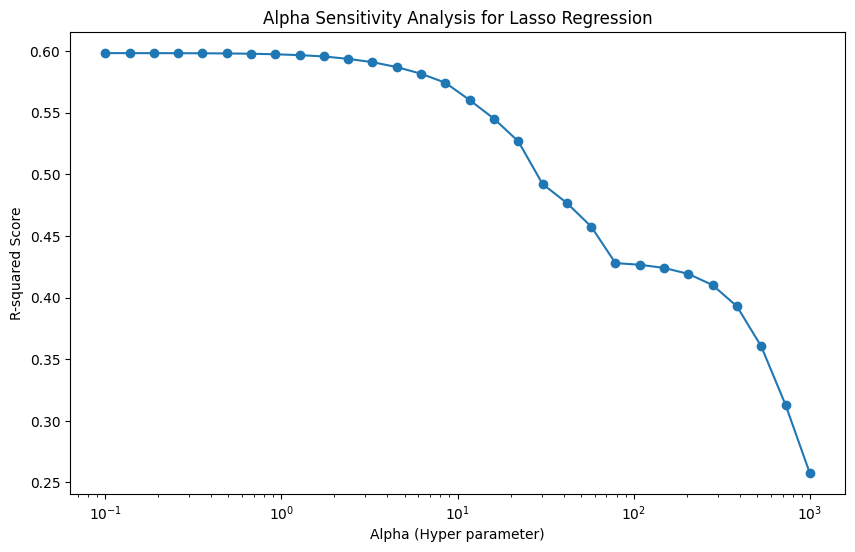

In [98]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(alpha_list, list(scores.values()), marker='o')
plt.xscale('log')  # Set x-axis to a logarithmic scale for better visualization
plt.xlabel('Alpha (Hyper parameter)')
plt.ylabel('R-squared Score')
plt.title('Alpha Sensitivity Analysis for Lasso Regression')
plt.show()

# Step 12: 

Rerun the lasso with that best value and identify all of the coefficiencts that were "selected" ie had non-zero values. Save these coefficient indices and labels to a list.

In [110]:
# Step 12 code

# Create Lasso object with best alpha
model_lasso = Lasso(alpha=best_alpha, random_state=0, max_iter=10000)

# Fit the model
y_train_hat_lasso = model_lasso.fit(X_train, y_train)

# Combine coefficients with their labels
coef_dict = dict(zip(feature_names, y_train_hat_lasso.coef_))

# Look at coefficients
# print("coefficients", coef_dict)

select_coef = []
# Append non-zero coefs to list
for var, coef in coef_dict.items():
    if coef > 0.01 or coef < -0.01:
        select_var.append((var, coef))

# View selected variables
print(select_var)


[('agb_observed_baccini_2000_30m', 1.1178444698633947), ('CRFVOL_M_sl1_250m', 3.6360303928262097), ('HISTPR_250m', 0.16851979492088145), ('OCDENS_M_sl1_250m', -7.1471066964145455), ('PHIHOX_M_sl1_250m', -0.04126857194753525), ('SLGWRB_250m', -0.048912276352112996), ('SLTPPT_M_sl1_250m', 0.4634661148714579), ('terrain_ruggedness_index_30s', -7.29404906078129), ('TEXMHT_M_sl1_250m', 2.2788866910504546), ('alt_30s', -3.0865771042501655), ('AWCh1_M_sl1_250m', 4.6483241969421), ('BDRICM_M_250m', 1.4994179044019034), ('BDRLOG_M_250m', -0.3267967876895696)]


In [113]:
selected_coefficient_labels = []
selected_coefficient_indices = []
for i in range(len(y_train_hat_lasso.coef_)):
    print('Coefficient', feature_names[i], 'was', y_train_hat_lasso.coef_[i])
    if abs(y_train_hat_lasso.coef_[i]) > 0.1:
        selected_coefficient_labels.append(feature_names[i])
        selected_coefficient_indices.append(i)

print('The selected variables are:', (selected_coefficient_labels, selected_coefficient_indices))

Coefficient agb_observed_baccini_2000_30m was 1.1178444698633947
Coefficient CRFVOL_M_sl1_250m was 3.6360303928262097
Coefficient HISTPR_250m was 0.16851979492088145
Coefficient OCDENS_M_sl1_250m was -7.1471066964145455
Coefficient PHIHOX_M_sl1_250m was -0.04126857194753525
Coefficient roughness_30s was -0.0
Coefficient SLGWRB_250m was -0.048912276352112996
Coefficient SLTPPT_M_sl1_250m was 0.4634661148714579
Coefficient terrain_ruggedness_index_30s was -7.29404906078129
Coefficient TEXMHT_M_sl1_250m was 2.2788866910504546
Coefficient wc2.0_bio_30s_01 was -0.0060665072378508385
Coefficient alt_30s was -3.0865771042501655
Coefficient AWCh1_M_sl1_250m was 4.6483241969421
Coefficient BDRICM_M_250m was 1.4994179044019034
Coefficient BDRLOG_M_250m was -0.3267967876895696
The selected variables are: (['agb_observed_baccini_2000_30m', 'CRFVOL_M_sl1_250m', 'HISTPR_250m', 'OCDENS_M_sl1_250m', 'SLTPPT_M_sl1_250m', 'terrain_ruggedness_index_30s', 'TEXMHT_M_sl1_250m', 'alt_30s', 'AWCh1_M_sl1_250m'

# Step 13:

Using Statsmodels, run an OLS version on the selected variables.

Use print to show the results table.

Write a description of any advantages this approach has over vanilla OLS.


In [121]:
# Step 13 code

# Select training data
X_train_selected = X_train[:, selected_coefficient_indices]

# Fit OLS model
model = OLS(y_train, X_train_selected)
results = model.fit()

# Print summary statistics
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.875
Model:                            OLS   Adj. R-squared (uncentered):              0.875
Method:                 Least Squares   F-statistic:                          6.376e+05
Date:                Mon, 11 Dec 2023   Prob (F-statistic):                        0.00
Time:                        04:07:26   Log-Likelihood:                     -5.1483e+06
No. Observations:             1000000   AIC:                                  1.030e+07
Df Residuals:                  999989   BIC:                                  1.030e+07
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Advantages over vanilla OLS

Thanks to the penalization of unimportant variables, lasso regressions are great
for variable control. This allows for a stream-lined way to perform variable
selection. Relately, the variable selection done through lasso regressions 
could help solve multicollinearity problems. Lastly, the penalization term 
helps prevent overfitting by punishing models that are overly complex while 
vanilla OLS could allow overfitting to go undetected.